In [1]:
!pip install spacy
!python -m spacy download es_core_news_sm

  Using cached nltk-3.7-py3-none-any.whl (1.5 MB)
  Using cached regex-2022.1.18-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (748 kB)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

In [3]:
dataset = pd.read_csv("../entry_dataset.csv", sep=";", index_col=0, parse_dates=["date"])
# dataset = pd.read_csv("gs://tfm_aideas_wb/entry_dataset.csv", sep=";", index_col=0, parse_dates=["date"])

In [4]:
query = dataset.copy()
positive_mask = query.r_adj > query.r_adj.quantile(0.8)
negative_mask = query.r_adj < query.r_adj.quantile(0.2)
positive_news = query.loc[positive_mask]
negative_news = query.loc[negative_mask]
positive_news["positive"] = True
negative_news["positive"] = False

C:\Users\jrselles\AppData\Local\Temp\ipykernel_10868\2831395542.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_news["positive"] = True
C:\Users\jrselles\AppData\Local\Temp\ipykernel_10868\2831395542.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_news["positive"] = False


In [5]:
pos_neg_news = pd.concat([positive_news, negative_news], axis=0)

In [6]:
del dataset
del positive_news
del negative_news

In [7]:
pos_neg_news.positive.value_counts()

False    10660
True     10646
Name: positive, dtype: int64

# Bag of words - Sin stopwords, lematización y alfanuméricos sólo

In [8]:
class LemmaTokenizer:
    def __init__(self):
        self.nlp = spacy.load("es_core_news_sm")
    def __call__(self, doc):
        doc = self.nlp(doc)
        tokens = []
        for token in doc:
            lexeme = self.nlp.vocab[token.text]
            if lexeme.is_stop == False and not lexeme.is_punct and token.text.isalnum():
                tokens.append(token.lemma_)
        return tokens

In [9]:
cv = CountVectorizer(lowercase=True, ngram_range = (1,1), tokenizer = LemmaTokenizer())

In [10]:
text_counts= cv.fit_transform(pos_neg_news["body"])

In [11]:
text_counts = text_counts.astype('float32')

No se ha hecho svd_solver='full' en el PCA porque tarda muchísimo y no acaba

In [12]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3)
weights = tsne.fit_transform(text_counts.todense())

c:\Users\jrselles\Desktop\tfm\venv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\jrselles\Desktop\tfm\venv\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\jrselles\Desktop\tfm\venv\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


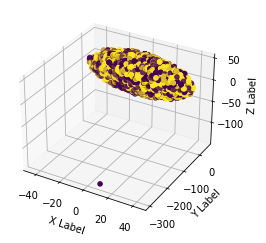

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(weights[:,0],
           weights[:,1],
           weights[:,2],
           c=pos_neg_news["positive"])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

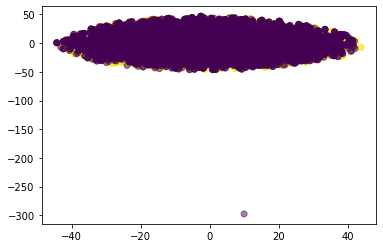

In [14]:
plt.scatter(weights[:,0], weights[:,1], c=pos_neg_news["positive"], alpha=0.5)

# Bag of words - Sin stopwords, lematización y alfanuméricos sólo y normalizado

In [15]:
from sklearn.preprocessing import StandardScaler
enc = StandardScaler()

In [16]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3)
weights = tsne.fit_transform(enc.fit_transform(text_counts.todense()))

c:\Users\jrselles\Desktop\tfm\venv\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\jrselles\Desktop\tfm\venv\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\jrselles\Desktop\tfm\venv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\jrselles\Desktop\tfm\venv\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will ch

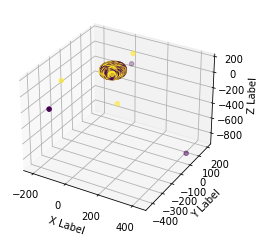

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(weights[:,0],
           weights[:,1],
           weights[:,2],
           c=pos_neg_news["positive"])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

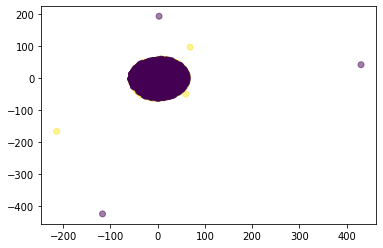

In [18]:
plt.scatter(weights[:,0], weights[:,1], c=pos_neg_news["positive"], alpha=0.5)

# TF-IDF - Sin stopwords, lematización y alfanuméricos sólo

In [19]:
pos_neg_news['clean_body'] = pos_neg_news['body'].apply(
    lambda x: ' '.join(LemmaTokenizer()(x.lower()))
    )

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf=TfidfVectorizer()
text_tf= tf.fit_transform(pos_neg_news["clean_body"])

In [21]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3)
weights = tsne.fit_transform(text_counts.todense())

c:\Users\jrselles\Desktop\tfm\venv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\jrselles\Desktop\tfm\venv\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\jrselles\Desktop\tfm\venv\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


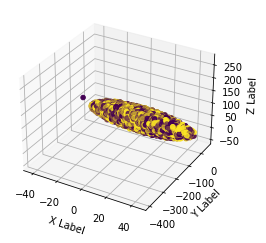

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(weights[:,0],
           weights[:,1],
           weights[:,2],
           c=pos_neg_news["positive"])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

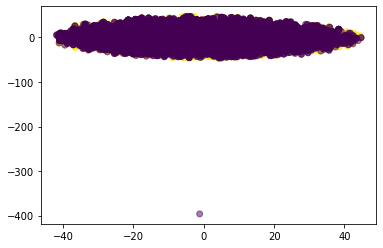

In [23]:
plt.scatter(weights[:,0], weights[:,1], c=pos_neg_news["positive"], alpha=0.5)